# Wrangle OpenStreetMap Data with SQL

The objective of this study is to practice data wrangling and query skills on OpenStreetMap osm format of data, which is essentially written in xml structure.

The major process is comprised of four steps:
* Step 1: Data Preview
* Step 2: Data Audit
* Step 3: Data Cleaning
* Step 4: Data Query by SQL

## 1. Study Area

My study area is Hong Kong (HK), where I lived and worked for 3 years. One thing unique about this area is that Hong Kong has interesting mixture of language usage:
* 2 written languages - English and Traditional Chinese due to that Hong Kong used to be a British colony between 1842 to 1997  
* 3 spoken languages - Cantonese, Mandarin and English. 

So it is expected that the mixed language usage might result in interesting data auditing and cleaning oppotunities. 

The original source link to download Hong Kong OSM is as below:
* MapZen: https://mapzen.com/data/metro-extracts/metro/hong-kong_china/

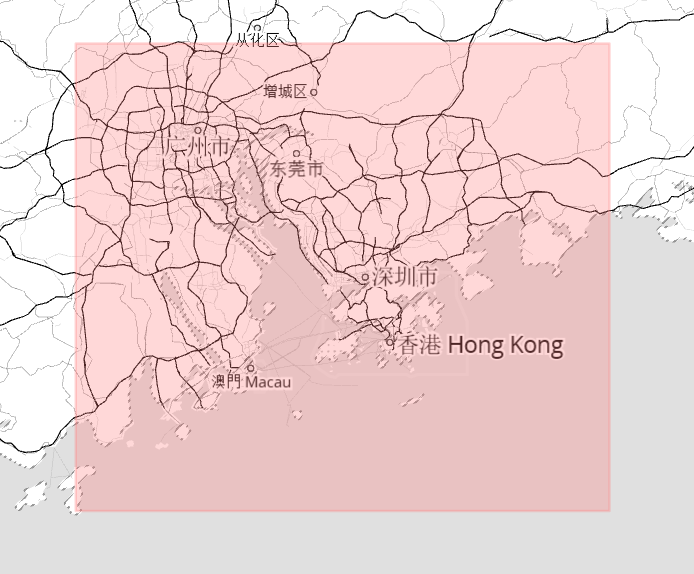

In [15]:
# Data Coverage from MapZen
from IPython.display import Image
Image(filename='Capture.png')

## 2. Data Wrangling Challenges

Four major challenges are encounterred in processing the data, which are: 
* 2a. Inconsistent City Names
* 2b. Inconsistent Phone Numbers
* 2c. Unexpected Zip Codes
* 2d. Localized style of Street Names

Details on issues and strategy to handle them and are disscussed as below.

In [186]:
import xml.etree.cElementTree as ET
from collections import defaultdict
from collections import Counter
import re
import pprint

OSMFILE ='sample.osm'
#OSMFILE='hong_kong.osm'

### 2a. Inconsistent City Names

The first thing I noticed is that the data coverage provided by MapZen not only including Hong Kong, but also including Macau and other mainland China cities. Lateron, when I tested the cityname in sample.osm, I noticed there are at least 3 causes for inconsistent city name:

1. Data outside Hong Kong: this happended due to the default coverage provided by MapZen does include adjacent cities such as Macau, Shenzhen and Guangzhou city.
2. Region names, District names and neighborhood names mistaken as City name:
     - Region name mistaken as city name (HK has 3 Regions)
     - District name mistaken as cityname (HK has 18 districts)
     - Neighborhood names: In fact, there's no offical defined list for HK neighborhoods, and the ones mistaken used as city name are some popular residential and commercial areas.
3. Mixed language: some were recorded in English, some in Chinese alone, and others were in bilingal.

In this study, our focus would be data within Hong Kong, therefore city names in situation 1 were left as they are. Our goal is to standadize City Name in situation 2 and 3.

The below code block showed the variations of city name.

In [187]:
# Audit city name
def audit_cityname(OSMFILE):
    city = set()
    for event, elem in ET.iterparse(OSMFILE):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib['k'] == "addr:city" or tag.attrib['k']=="cityname":
                    city.add(tag.attrib['v'])
    return(city)
 

audit_cityname(OSMFILE)

{'Central',
 'Ta Kwu Ling',
 'Tai Po',
 'Wan Chai',
 'Zhuhai',
 '元朗 Yuen Long',
 '屯門 Tuen Mun',
 '梅窩 Mui Wo',
 '江门市',
 '深圳市',
 '火炭 Fo Tan',
 '紅磡 Hung Hom',
 '荃灣 Tsuen Wan',
 '香港 Hong Kong'}

### Strategy to fix city name

In order to clean up inconsistent city names caused by region, district or neighborhood names, as well as language issues alltogether, I looped regular expression to check city name while iterative parsing.

If city name is in the combined list of HK region, districts and neighborhoods,the value will be updated with the standardized city name, which is a bilingual version--'香港 Hong Kong'.

In [188]:
# Create list for Hong Kong regions, districts
regions = ['Islands', 'Kowloon', 'New Territories']
districts = ['Islands', 'Kwai Tsing', 'North', 'Sai Kung',
            'Sha Tin', 'Tai Po', 'Tsuen Wan', 'Tuen Mun',
            'Yuen Long', 'Kowloon City', 'Kwun Tong',
            'Sham Shui Po', 'Wong Tai Sin', 'Yau Tsim Mong',
            'Central', 'Western', 'Eastern','Southern', 
            'Wan Chai']
neighborhoods = ['Ta Kwu Ling', 'Hung Hom','Tsuen Wan','Mui Wo','Fo Tan']
combine = regions + districts + neighborhoods

# Create regular expression
# Join array elements with "|" as glue
subcity = re.compile('|'.join(combine))


In [208]:
def update_cityname(cityname):    
    m=subcity.search(cityname)
    if m:
        cityname='香港 Hong Kong'
    else:
        cityname=cityname
    return cityname

city = set()
for event, elem in ET.iterparse(OSMFILE):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if tag.attrib['k'] == "addr:city" or tag.attrib['k']=="cityname":
                city_name=update_cityname(tag.attrib['v'])
                #update_cityname(city_name)
                city.add(city_name)
city

{'Zhuhai', '江门市', '深圳市', '香港 Hong Kong'}

Now we can see the city names are only 4, and the first three are cities in adjacent mainland China area, and the last name is the standardized form of Hong Kong.

Let's move to the next challenge.

### 2b. Inconsistent Phone Numbers

Phone numbers are inconsistent in three different ways:
1. Phone number from Macau (+853 xxxx xxxx)
2. Phone number missing Hong Kong region code (+852)
3. No space between the last 8 digits

And the standard Hong Kong phone number should be: +852 xxxx xxxx

In [24]:
# Audit phone
def audit_phone(OSMFILE):
    phone_list = []
    for event, elem in ET.iterparse(OSMFILE):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib['k'] == "phone":
                    phone_list.append(tag.attrib['v'])
                    
    return(phone_list)

audit_phone('sample.osm')

['27391515',
 '+853 2850 0400',
 '+853 2881 3306',
 '+852 2822 0228',
 '+852 25255044',
 '+852 2505 6228',
 '+852 2870 9323',
 '+852 2897 1118',
 '25215041',
 '+853 2888 1122',
 '+853 2893 8963',
 '+853 2883 9933',
 '83858988']

### Strategy to fix phone number

Here we mainly going to deal with two variations:
* Missing Area Code and no separator: XXXXXXXX
* With Area Code, but no separator: +852 XXXXXXXX


In [209]:
def update_phone(phone):
    if re.compile(r'^(\d{8})$').search(phone):
        phone = '+852'+' '+phone[0:4]+' '+phone[4:]
    elif re.compile(r'^\+852\s(\d{8})$').search(phone):
        phone = phone[0:9]+' '+phone[9:]
    else:
        phone=phone
    return phone

phone_list = []
for event, elem in ET.iterparse(OSMFILE):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if tag.attrib['k'] == "phone":
                phone=update_phone(tag.attrib['v'])
                phone_list.append(phone)
phone_list

['+852 2739 1515',
 '+853 2850 0400',
 '+853 2881 3306',
 '+852 2822 0228',
 '+852 2525 5044',
 '+852 2505 6228',
 '+852 2870 9323',
 '+852 2897 1118',
 '+852 2521 5041',
 '+853 2888 1122',
 '+853 2893 8963',
 '+853 2883 9933',
 '+852 8385 8988']

### 2c. Unexpected Zip Codes

Unlike United State, Hong Kong and Macau's Postal Services are not based on zipcode or postal code system. So to check Zipcode, I should see nothing if the data coverage is Hong Kong. However, due to the fact that other mainland China cities do have zipcodes, and the format is 6 digits, I would expect to see:
* 6 digits zipcode: for mainland China cities
* 0000: I also had personal experience that when some international delivery require zipcode information, most company or people will just use 0000.
* 999077: from wikipedia search for Hong Kong zipcode, even though no one is actually using it.
* 999078: from wikipedia search for Macau zipcode, even though no one is actually using it.

In [231]:
# Audit zipcode
def audit_zipcode(OSMFILE):
    post_list = []
    for event, elem in ET.iterparse(OSMFILE):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib['k'] == "addr:postcode":
                    post_list.append(tag.attrib['v'])
    return(post_list)

audit_zipcode(OSMFILE)

['DD91 3719', 'DD78 1912', 'DD5 1116']

### No special fix to Zipcode

The zipcode auditing results returned something very alien, which neither the mainland China zipcodes nor the unused Hong Kong or Macau postal code. 

So for this study, I decided to leave zipcode information as is.

### 2d. Localized style of Street Names

One of the typical issue is that in Hong Kong, it is quite common to have orientation at the end of street name.

So the first fix is to add orientation to the expected list.


In [229]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected= ["Street", "Avenue", "Road", "Boulevard", "Drive", 
           "Lane", "Path", "Trail", "Parkway",
           "Central","East", "West", "North", "South"]

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")
    
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

st_types_before = audit(OSMFILE)
print("WEIRDO Street Types BEFORE:\n")
pprint.pprint(dict(st_types_before))



WEIRDO Street Types BEFORE:

{'Cais': {'碼頭前地 Largo do Cais'},
 'Close': {'南灣坊 South Bay Close'},
 'Long': {'青山公路 - 元朗段 Castle Peak Road - Yuen Long'},
 'Ranch': {'Sea Ranch'},
 'Station': {'East Tsim Sha Tsui Station'},
 'Terminal': {'Ocean Terminal'},
 'Tsai': {'O Tsai'},
 'Tseng': {'青山公路－深井段 Castle Peak Road – Sham Tseng'},
 '友和路': {'友和路'},
 '百花五路': {'百花五路'},
 '高新南一道': {'高新南一道'}}


### Update Street Names

After adding the orientation to the expected list, most street names are validated now. But we still need to deal with some streets with Chinese name only.

For those streets, my strategy is to add the corresponded English translation to the end of the street name.

In [232]:
mapping = { u"路": "Road",
            u"徑" : "Path",
            u"道" : "Road"
            }

def update_street(name, mapping):
    for target in mapping.keys():
        if target in name:
            name = name+' '+mapping[target]
        else:
            name=name
    return name

street_types = defaultdict(set)
for event, elem in ET.iterparse(OSMFILE, events=("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_street_name(tag):
                newname=update_street(tag.attrib['v'],mapping)
                audit_street_type(street_types, newname)

print("WEIRDO Street Types AFTER:\n")
pprint.pprint(dict(street_types))                
                

WEIRDO Street Types AFTER:

{'Cais': {'碼頭前地 Largo do Cais'},
 'Close': {'南灣坊 South Bay Close'},
 'Ranch': {'Sea Ranch'},
 'Station': {'East Tsim Sha Tsui Station'},
 'Terminal': {'Ocean Terminal'},
 'Tsai': {'O Tsai'}}


### Street Name Clean Results:

From the above two cells we can see, after cleaning, weirdo street types reduced. 
The six types listed as weirdo are left as they are because:
* 'Cais': this one located in Macau, therefore it is not included for this practice.
* The other five types are actually places in Hong Kong, but they could be street names or place names or even land property names. I decided not to change them.

In [ ]:
def update_street(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])

## 3. Data Overview

### 3a. File Size

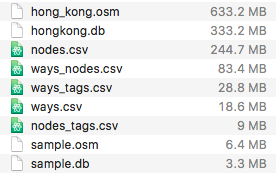

In [233]:
from IPython.display import Image
Image(filename='File_size.png')

### 3b. SQL Query

After importing five .csv file into hongkong.db by using csv_to_db.py, the below SQL queries are performed in terminal interface.

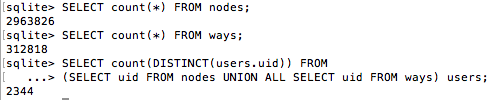

In [235]:
from IPython.display import Image
Image(filename='query1.png')

### Number of nodes : 2,963,826

In [ ]:
sqlite> SELECT count(*) FROM nodes;

2963826

### Number of ways: 312,818

In [ ]:
sqlite> SELECT count(*) FROM ways;

312818

### Number of Unique Users: 2344

In [ ]:
sqlite> SELECT count(DISTINCT(users.uid)) FROM
   ...> (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) users;

2344

### Top 10 Contributors

In [ ]:
sqlite> SELECT users.user, count(*) as num FROM
   ...> (SELECT user FROM nodes UNION ALL SELECT user FROM ways) users
   ...> GROUP BY users.user
   ...> ORDER BY num DESC
   ...> LIMIT 10;

hlaw|464147
MarsmanRom|285455
羊角忠实黑|185014
Popolon|156306
sn0wblind|146617
katpatuka|112852
fsxy|92942
fdulezi|84110
KX675|79663
tomlee721|57704

### Additional Exploration

### Top 10 Cuisines

In [ ]:
sqlite> SELECT value,count(*) as cnt FROM nodes_tags
   ...> WHERE key == 'cuisine'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 10;

In [ ]:
chinese|223
coffee_shop|99
burger|87
burger;american|60
japanese|55
chicken|37
noodle|24
indian|18
regional|18
thai|18

### Top 10 Tourism


In [ ]:
sqlite> SELECT value, count(*) as cnt FROM nodes_tags
   ...> WHERE key == 'tourism'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 10;

In [ ]:
information|1341
attraction|515
hotel|324
viewpoint|173
guest_house|146
picnic_site|98
artwork|87
hostel|64
camp_site|48
museum|41

### Top 10 Landuse

In [ ]:
sqlite> SELECT value, count(*) as cnt FROM ways_tags
   ...> WHERE key == 'landuse'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 10;

In [ ]:
residential|7776
industrial|1404
commercial|1173
grass|1104
basin|1012
construction|685
forest|577
reservoir|552
farmland|511
meadow|258

### Top 10 Natural Resources

In [ ]:
sqlite> SELECT value, count(*) as cnt FROM ways_tags
   ...> WHERE key == 'natural'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 10;

In [ ]:
water|7878
coastline|952
wood|797
beach|273
scrub|165
grassland|155
cliff|146
sand|101
wetland|82
tree_row|27

### Top 10 Places in Hong Kong

In [ ]:
sqlite> SELECT value, count(*) as cnt FROM nodes_tags
   ...> WHERE key == 'en' and type == 'name'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 10;

In [ ]:
7-Eleven|270
McDonald's|88
Wellcome|59
Starbucks Coffee|33
Pacific Coffee|29
Tuen Mun Road Interchange|27
Circle K|26
Café de Coral|23
Bank of China|22
Millennium City|20

### Top 5 Speed Limits

In [ ]:
sqlite> SELECT value, count(*) as cnt FROM ways_tags
   ...> WHERE key=='maxspeed'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 5;

In [ ]:
20|1612
50|784
70|590
80|562
140|228

## 4. Other ideas

One of my major reflection about this data wrangling task is that different languages does bring data processing difficulties. From creating sample.osm to importing csv files to database, there are a lot of small variations in terms of regular expressions, unicode issues, and even python versions. 

Another thing I've been thinking a lot is what is the best way to know what to query. Before I started to create my queries, I wanted to know what are the major fields in our data, and below is a example to get the most common 25 attributes from Way element. Then I started to build SQL query based on those frequent attributes. However the challenge is that sometimes key attributes can be ambiguous. 

For example, the below example is based on sample.osm, and I thought I could get Top 5 bridges in Hong Kong after processing the original data. It turned out the 'bridge' only contain the information more like 'status'.

Last but not least, I also played with the same Hong Kong data downloaded from OpenStreetMap in GIS, in which the input file is in GIS shapefile format. Most of work we did here like parsing, transformating to database to get information could be accomplished by GIS as well. The best part is the information has been organized in flat format already, so one can directly query and create visualization, which actually take way less time and effort. 


In [ ]:
sqlite> SELECT value, count(*) as cnt FROM ways_tags
   ...> WHERE key == 'bridge'
   ...> GROUP BY value
   ...> ORDER BY cnt DESC
   ...> LIMIT 5;
yes|18884
viaduct|1523
suspension|15
covered|6
no|3



In [242]:
# Top 10 k_tag for Way elements
k_types=[]
for event,elem in ET.iterparse(OSMFILE):
    if elem.tag=='way':
        for child in elem.iter("tag"):
            k_types.append(child.attrib['k'])
Counter(k_types).most_common(25)

[('highway', 1840),
 ('name', 781),
 ('oneway', 708),
 ('building', 647),
 ('name:zh', 456),
 ('name:en', 443),
 ('layer', 270),
 ('bridge', 212),
 ('source', 191),
 ('landuse', 151),
 ('building:levels', 129),
 ('lanes', 122),
 ('ref', 119),
 ('addr:housenumber', 114),
 ('natural', 108),
 ('addr:street', 106),
 ('waterway', 88),
 ('leisure', 67),
 ('amenity', 64),
 ('maxspeed', 61),
 ('railway', 60),
 ('name:pt', 51),
 ('bicycle', 50),
 ('foot', 48),
 ('service', 46)]

## 5. Reference
* Udacity Forum: [Deal with Chinese](https://discussions.udacity.com/t/how-should-i-deal-with-chinese/177797/3)
* Stackoverflow: [Match string from a list](http://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python)
* Github Repo:
    1. https://github.com/svar123/Data-wrangling
    2. https://github.com/SimonTong22/UD-P3-SQL/blob/master/OpenStreetMap%20Data%20Case%20Study_Tong.pdf
    3. https://github.com/lifengleaf/OpenStreetMap-Project-Udacity/blob/master/audit.py
    4. https://github.com/Dalaska/Udacity-Data-Wrangling-Clean-OpenStreetMap/blob/master/step1_audit.py